# Policy Gradient

In reinforcement learning, the goal is to find a policy that maximizes the expected cumulative reward over time. Policy Gradient (PG) methods are a class of algorithms for finding such policies in which the policy is represented by a parameterized function, such as a neural network. The key idea behind PG methods is to adjust the parameters of the policy in the direction that increases the expected reward. This is done by computing the gradient of the expected reward with respect to the policy parameters and updating the parameters in the direction of the gradient.

Unfortunately, calculating exact policy gradient requires iterating over the entire state-action space, which is unfeasible in most problems. As such, we estimate the gradient with a sample of recent transitions, which were sampled according to the policy. In its simplest form, PG is equal to:

$$
\nabla_{\theta} J = \underset{s \sim p^{\pi}_{*}}{\mathbb{E}} ~ \underset{a \sim \pi}{\mathbb{E}} ~ Q^{\pi} (s, a) ~ \nabla_{\theta} \log \pi_{\theta} (a | s)
$$

Where $p^{\pi}_{*}$ is the discounted stationary distribution, $\pi_{\theta}(a|s)$ is the policy and $Q^{\pi} (s, a)$ denotes the Q-value under policy. Some of the popular policy gradient algorithm are Actor-Critic and PPO. These algorithm use different techniques to estimate the gradient and update the policy.

Tasks:

1. Run the **PolicyGradient** agent. Plot mean+std of rewards during the training.
2. Implement the *update* method for **BaselinedPolicyGradient** class. Run the agent, plot mean+std of rewards during the training.
3. Implement the *update* method for **ActorCritic** class. Run the agent, plot mean+std of rewards during the training.

We import required modules and fix hyperparamters:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import time
import numpy as np

In [2]:
# do not change!
class parse_args:
    def __init__(self):
        self.gym_id = "CartPole-v0"
        self.batch_size = 32
        self.hidden_dim = 32
        self.learning_rate = 5e-3
        self.discount = 0.99
        self.timesteps = 10000
        self.repeats = 10
        self.eval_steps = 500
        self.cuda = True
        env = gym.make(self.gym_id)
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")

args = parse_args()

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


We define a policy network (**ActorNetwork**) and a value network (**CriticNetwork**). Value network has multiple uses, but we will initially use it to bootstrap Q-values of unfinished episodes.

Why do we need such bootstrap? Our environment can run up to 200 steps before termination. Given batch size of 32, we will never be able to get entire episode in one batch. As PG requires Q-values of all state-actions in the batch, we have to find a way of calculating the Q-values past our batch.

In [3]:
class ActorNetwork(nn.Module):
    def __init__(self, args):
        super(ActorNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(args.state_size, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, args.action_size))
        
    def forward(self, x):
        return nn.Softmax(1)(self.layers(x))
    
class CriticNetwork(nn.Module):
    def __init__(self, args):
        super(CriticNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(args.state_size, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, 1))
        
    def forward(self, x):
        return self.layers(x)

Below, we implement the PG agent. There are two important methods here:

1. *get_qvalues* - calculate Q-values for the batch. If final state is not terminating, use value network to estimate value of past final state.
2. *update* - update actor and citic networks. 

In [4]:
class PolicyGradient(nn.Module):
    def __init__(self, args):
        super(PolicyGradient, self).__init__()
        self.args = args
        self.init_networks()
        
    def reset(self):
        self.logprobs = torch.zeros(self.args.batch_size)
        self.values = torch.zeros(self.args.batch_size)
        self.rewards = torch.zeros(self.args.batch_size)
        self.terminals = torch.zeros(self.args.batch_size)
        self.idx = 0
        
    def init_networks(self):
        self.actor = ActorNetwork(self.args)
        self.critic = CriticNetwork(self.args)
        self.optimizer = optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=self.args.learning_rate)
        self.reset()

    def add(self, logprob, value, reward, terminal):
        self.logprobs[self.idx] = logprob
        self.values[self.idx] = value
        self.rewards[self.idx] = reward
        self.terminals[self.idx] = terminal
        self.idx += 1

    def get_action_and_value(self, x):
        probs = self.actor(x)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), self.critic(x)

    def get_qvalues(self, final_state):
        with torch.no_grad():
            final_state_value = self.critic(final_state)
        q_values = torch.zeros_like(self.rewards).to(self.args.device)
        for timestep in reversed(range(self.args.batch_size)):
            next_value = final_state_value if timestep == (self.args.batch_size - 1) else q_values[timestep + 1]
            q_values[timestep] = self.rewards[timestep] + self.args.discount * (1 - self.terminals[timestep]) * next_value
        return q_values
    
    def update(self, q_values):
        policy_loss = -(self.logprobs * q_values).mean()
        value_loss = (self.values - q_values).pow(2).mean()
        loss = (policy_loss + 0.5*value_loss)
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        self.reset()
        
    def evaluate(self, samples):
        with torch.no_grad():
            env_test = gym.make(self.args.gym_id)
            eval_reward = 0
            for i in range(samples):
                state = env_test.reset()
                episode_reward = 0
                while True:
                    action, _, _ = self.get_action_and_value(torch.tensor(state).unsqueeze(0))
                    next_state, reward, terminal, _ = env_test.step(action)
                    episode_reward += reward
                    state = next_state
                    if terminal:
                        eval_reward += episode_reward/samples
                        break
        return eval_reward

Finally, a function to train the agent:

In [5]:
def train(args, agent):
    rewards = np.zeros((args.timesteps//args.eval_steps, args.repeats))
    for seed in range(args.repeats):
        env = gym.make(args.gym_id)
        agent.init_networks()
        state = env.reset()
        start_time = time.time()
        for step in range(args.timesteps):
            action, logprob, value = agent.get_action_and_value(torch.tensor(state).unsqueeze(0))
            next_state, reward, terminal, _ = env.step(action)
            agent.add(logprob, value, reward, terminal)
            state = next_state
            if agent.idx == args.batch_size:
                q_values = agent.get_qvalues(torch.tensor(state).unsqueeze(0))
                agent.update(q_values)
            if (step+1) % args.eval_steps == 0:
                eval_rewards = agent.evaluate(5)
                rewards[step//args.eval_steps, seed] = eval_rewards
                if (step+1) % (10 * args.eval_steps) == 0:
                    print(f"step={step+1}, eval_return={np.round(eval_rewards, 1)}, samples_per_sec={int(step / (time.time() - start_time))}")
            if terminal:
                state = env.reset()
                episode_reward = 0
    return rewards

In [6]:
agent = PolicyGradient(args).to(args.device)
rewards = train(args, agent)

step=5000, eval_return=54.8, samples_per_sec=912
step=10000, eval_return=126.2, samples_per_sec=840
step=5000, eval_return=62.6, samples_per_sec=946
step=10000, eval_return=179.6, samples_per_sec=852
step=5000, eval_return=58.2, samples_per_sec=963
step=10000, eval_return=112.8, samples_per_sec=890
step=5000, eval_return=56.8, samples_per_sec=977
step=10000, eval_return=134.4, samples_per_sec=901
step=5000, eval_return=30.6, samples_per_sec=993
step=10000, eval_return=158.0, samples_per_sec=860
step=5000, eval_return=80.2, samples_per_sec=938
step=10000, eval_return=127.0, samples_per_sec=831
step=5000, eval_return=61.4, samples_per_sec=1006
step=10000, eval_return=127.6, samples_per_sec=864
step=5000, eval_return=82.2, samples_per_sec=952
step=10000, eval_return=134.8, samples_per_sec=874
step=5000, eval_return=93.6, samples_per_sec=971
step=10000, eval_return=194.8, samples_per_sec=851
step=5000, eval_return=63.0, samples_per_sec=880
step=10000, eval_return=156.2, samples_per_sec=775

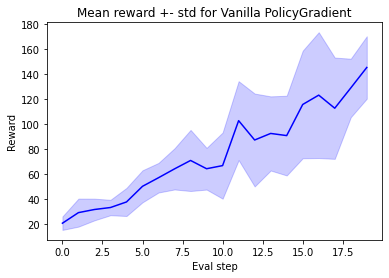

In [39]:
# GRAPH RESULTS HERE (MEAN + STD)
from matplotlib import pyplot as plt

def plot_rewards(rewards, name, color='b'):
  x = range(len(rewards))
  y = rewards.mean(axis=1)
  std = rewards.std(axis=1)
  plt.plot(x, y, f'{color}-', label=name)
  plt.fill_between(x, y-std, y+std, color=color, alpha=0.2)
  plt.title(f'Mean reward +- std for {name}')
  plt.xlabel('Eval step')
  plt.ylabel('Reward')

plot_rewards(rewards, 'Vanilla PolicyGradient')

PG estimate has big variance - the estimate will vary a lot depending on the states and actions sampled. This variance is known to impact the sample efficiency and final performance of the agent. Although there are many strategies fo PG variance reduction, there is one trick that became indispensable in modern implementations of PG - baseline trick. But before we get to this, lets have one more look at the standard PG estimate:

$$
\nabla_{\theta} J = \underset{s \sim p^{\pi}_{*}}{\mathbb{E}} ~ \underset{a \sim \pi}{\mathbb{E}} ~ Q^{\pi} (s, a) ~ \nabla_{\theta} \log \pi_{\theta} (a | s)
$$

As mentioned in the lecture, PG nature is quite simple - increase the probability of good actions and decrease the probability of bad ones. 'Good' and 'bad' refer to Q-values associated with given actions. But what if all Q-values are positive? The gradient update will try to increase the probabilities of all sampled actions, with the increase being proportional to the Q-value (as stems from the equation above). As such, given positive Q-values, the probabilities of bad actions are also increased - just by a smaller amount that probabilities of actions with bigger Q-values. 

Baseline variance reduction tackles exactly that. The idea is to subtract a "baseline" from the Q-values, which does not affect the optimal policy, but reduces the variance of the gradients. It is proven that as long as the baseline does not depend on the action, its value will not bias the PG (however, inadequate baseline can actually increase the variance :)). So, what is a good baseline?

The simplest version subtracts batch average of Q-values from each Q-value:

$$
\nabla_{\theta} J = \sum_{i=1}^{B} \frac{1}{B} \bigl( Q^{\pi} (s_i, a_i) - \frac{\sum Q^{\pi} (s_i, a_i)}{B} \bigr) \nabla_{\theta} \log \pi_{\theta} (a_i | s_i)
$$

Where B is the batch size and $\frac{\sum Q^{\pi} (s_i, a_i)}{B}$ is the average Q-value in the batch.

In [27]:
class BaselinedPolicyGradient(PolicyGradient):
    
    def __init__(self, args):
        super(BaselinedPolicyGradient, self).__init__(args)
        
    def update(self, q_values):
        q_batch_mean = q_values.mean().detach()
        policy_loss = -(self.logprobs * (q_values - q_batch_mean)).mean()
        value_loss = (self.values - q_values).pow(2).mean()
        loss = (policy_loss + 0.5*value_loss)
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        self.reset()

In [28]:
agent = BaselinedPolicyGradient(args).to(args.device)
rewards2 = train(args, agent)

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


step=5000, eval_return=58.4, samples_per_sec=845
step=10000, eval_return=88.4, samples_per_sec=756
step=5000, eval_return=114.0, samples_per_sec=872
step=10000, eval_return=109.2, samples_per_sec=775
step=5000, eval_return=60.2, samples_per_sec=863
step=10000, eval_return=119.2, samples_per_sec=766
step=5000, eval_return=54.2, samples_per_sec=891
step=10000, eval_return=184.8, samples_per_sec=715
step=5000, eval_return=65.8, samples_per_sec=912
step=10000, eval_return=160.4, samples_per_sec=813
step=5000, eval_return=61.4, samples_per_sec=911
step=10000, eval_return=116.2, samples_per_sec=781
step=5000, eval_return=63.0, samples_per_sec=850
step=10000, eval_return=185.0, samples_per_sec=704
step=5000, eval_return=76.4, samples_per_sec=888
step=10000, eval_return=200.0, samples_per_sec=742
step=5000, eval_return=64.6, samples_per_sec=835
step=10000, eval_return=187.0, samples_per_sec=742
step=5000, eval_return=101.0, samples_per_sec=872
step=10000, eval_return=153.2, samples_per_sec=696

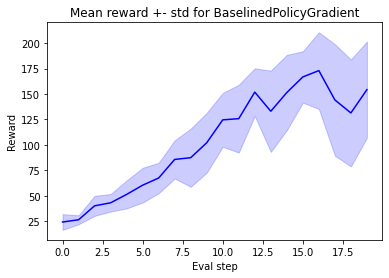

In [26]:
# GRAPH RESULTS HERE (MEAN + STD)
plot_rewards(rewards2, 'BaselinedPolicyGradient')

The most popular approach is to use state value as the baseline. Then, the gradient is well centered - probability of actions with Q-values smaller than state value will be decreased and probability of actions with Q-values bigger than state value will be increased. Obviously, we do not know the values associated with each state. To this end, we leverage a **CriticNetwork**. This network outputs value of a state and is trained using MSE using Q-values as targets. Traditionally, PG algorithm that uses value network for baseline variance reduction is called Actor-Critic. Actor Critic update is calculated with:

$$
\nabla_{\theta} J = \sum_{i=1}^{B} \frac{1}{B} \bigl( Q^{\pi} (s_i, a_i) - V_{\phi}(s) \bigr) \nabla_{\theta} \log \pi_{\theta} (a_i | s_i)
$$

Where $\bigl( Q^{\pi} (s_i, a_i) - V_{\phi}(s) \bigr)$ is referred to as **advantage**.

In [43]:
class ActorCritic(PolicyGradient):
    
    def __init__(self, args):
        super(ActorCritic, self).__init__(args)
        
    def update(self, q_values):
        policy_loss = -(self.logprobs * (q_values - self.values).detach()).mean()
        value_loss = (self.values - q_values).pow(2).mean()
        loss = (policy_loss + 0.5*value_loss)
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        self.reset()

In [46]:
agent = ActorCritic(args).to(args.device)
rewards3 = train(args, agent)

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


step=5000, eval_return=68.6, samples_per_sec=849
step=10000, eval_return=189.6, samples_per_sec=718
step=5000, eval_return=100.0, samples_per_sec=832
step=10000, eval_return=200.0, samples_per_sec=692
step=5000, eval_return=151.8, samples_per_sec=793
step=10000, eval_return=200.0, samples_per_sec=691
step=5000, eval_return=60.2, samples_per_sec=881
step=10000, eval_return=200.0, samples_per_sec=727
step=5000, eval_return=101.2, samples_per_sec=855
step=10000, eval_return=169.0, samples_per_sec=705
step=5000, eval_return=171.0, samples_per_sec=849
step=10000, eval_return=175.4, samples_per_sec=719
step=5000, eval_return=103.8, samples_per_sec=860
step=10000, eval_return=156.2, samples_per_sec=708
step=5000, eval_return=179.0, samples_per_sec=774
step=10000, eval_return=182.2, samples_per_sec=709
step=5000, eval_return=57.2, samples_per_sec=890
step=10000, eval_return=197.6, samples_per_sec=786
step=5000, eval_return=179.8, samples_per_sec=820
step=10000, eval_return=157.2, samples_per_s

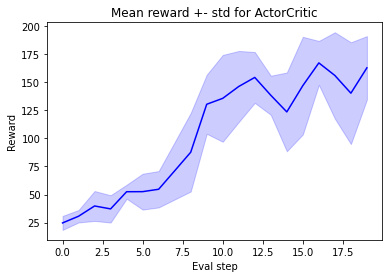

In [33]:
# GRAPH RESULTS HERE (MEAN + STD)
plot_rewards(rewards3, 'ActorCritic')

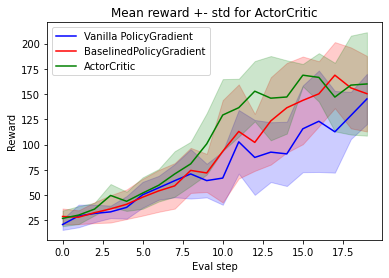

In [45]:
# GRAPH ALL RESULTS HERE (MEAN + STD)
plot_rewards(rewards, 'Vanilla PolicyGradient', color='b')
plot_rewards(rewards2, 'BaselinedPolicyGradient', color='r')
plot_rewards(rewards3, 'ActorCritic', color='g')
plt.legend()
plt.show()